# Compute post response inhibition for gridcells

In [80]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import expipe
import os
import pathlib
import numpy as np
import exdir
import pandas as pd
import optogenetics as og
import quantities as pq
import shutil
from distutils.dir_util import copy_tree
import seaborn as sns
from functools import reduce
from septum_mec.analysis.stimulus_response import stimulus_response_latency, compute_response
import scipy.stats
from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from septum_mec.analysis.statistics import load_data_frames, make_paired_tables, make_statistics_table 
tqdm_notebook.pandas()

%matplotlib inline

In [82]:
std_gaussian_kde = 0.04
window_size = 0.05
tmin = 0. # delay to compute FWHM after stimulus onset

In [83]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [84]:
output = pathlib.Path('output/stimulus-post-response-gridcell-inhibition')
(output / 'data').mkdir(parents=True, exist_ok=True)
(output / 'figures').mkdir(parents=True, exist_ok=True)
(output / 'statistics').mkdir(parents=True, exist_ok=True)

In [85]:
df = load_data_frames()[0]

Number of sessions above threshold 194
Number of animals 4
Number of individual gridcells 139
Number of gridcell recordings 230


In [88]:
stim_df = df.query('p_e_peak == p_e_peak and gridcell')
print(len(stim_df))

102


In [89]:
psth_start = -0.01
window_size = 0.05
times = np.arange(psth_start, window_size, 1e-4)
tmin = 0.005
psths = []
fwhms = []
for i, row in tqdm(stim_df.iterrows(), total=len(stim_df)):
    action_id = row['action']
    channel_group = row['channel_group']
    unit_name = row['unit_name']
    name = f'{action_id}_{channel_group}_{unit_name}'
    spike_times = data_loader.spike_train(action_id, channel_group, unit_name)
    
    spike_times = np.array(spike_times)
    
    stim_times = data_loader.stim_times(action_id)
    
    if stim_times is None:
        continue
    
    stim_times = np.array(stim_times)
    
    _, spikes, kernel, p_e, p_i = stimulus_response_latency(
        spike_times, stim_times, window_size, std_gaussian_kde)
    
    if all(np.isnan([p_e, p_i])):
        continue
    
    psths.append(kernel(times))

In [90]:
stim_df["psth"] = psths

In [199]:
baseline_interval = [-0.005, 0.005]
post_interval_11 = [0.015, 0.025]
post_interval_30 = [0.015, 0.025]
post_post_interval_30 = [0.025, 0.04]

bl_avgs = []
post_avgs = []
post_post_avgs = []
for i, row in stim_df.iterrows():
    bl_idxs = np.searchsorted(times, baseline_interval, side="right")
    avg_bl = np.mean(row.psth[bl_idxs])
    if row.frequency == 11:
        post_idxs = np.searchsorted(times, post_interval_11, side="right")
    else:
        post_idxs = np.searchsorted(times, post_interval_30, side="right")
        post_post_idxs = np.searchsorted(times, post_post_interval_30, side="right")
        
    avg_post = np.mean(row.psth[post_idxs])
    avg_post_post = np.mean(row.psth[post_idxs])
    bl_avgs.append(avg_bl)
    post_avgs.append(avg_post)
    post_post_avgs.append(avg_post_post)

In [200]:
stim_df["psth_avg_baseline"] = bl_avgs
stim_df["psth_avg_post"] = post_avgs
stim_df["psth_avg_post_post"] = post_post_avgs

In [201]:
columns = ["psth_avg_baseline", "psth_avg_post", "psth_avg_post_post"]
results, labels = make_paired_tables(stim_df, columns)

In [202]:
results['gridcell']['psth_avg_baseline']

,Baseline I,entity,unit_idnum,channel_group,date,11 Hz,Baseline II,30 Hz
34,NaN,1833,13,0,20719,10.312848,NaN,13.729710
35,NaN,1833,14,0,20719,18.413102,NaN,NaN
68,NaN,1833,26,0,200619,NaN,NaN,11.650629
74,NaN,1833,31,0,260619,NaN,NaN,7.264127
5,NaN,1833,32,0,260619,21.395772,NaN,6.694115
...,...,...,...,...,...,...,...,...
11,NaN,1849,684,0,220319,15.949919,NaN,NaN
1,NaN,1849,715,1,110319,8.124076,NaN,NaN
15,NaN,1849,724,1,280219,20.009519,NaN,10.822535
72,NaN,1849,835,4,150319,NaN,NaN,8.010018


In [203]:
results_11_and_30 = {}
for label in ['11 Hz', '30 Hz']:
    values = pd.DataFrame()
    for i, row in results['gridcell']['psth_avg_baseline'].iterrows():
        values.loc[i, 'psth_avg_baseline'] = results['gridcell']['psth_avg_baseline'].loc[i, label]
        values.loc[i, 'psth_avg_post'] = results['gridcell']['psth_avg_post'].loc[i, label]
        values.loc[i, 'psth_avg_post_post'] = results['gridcell']['psth_avg_post_post'].loc[i, label]
        values.loc[i, 'entity'] = results['gridcell']['psth_avg_post'].loc[i, 'entity']
        values.loc[i, 'unit_idnum'] = results['gridcell']['psth_avg_post'].loc[i, 'unit_idnum']
    values.unit_idnum = values.unit_idnum.values.astype(int)
    values.entity = values.entity.values.astype(int).astype(str)
    results_11_and_30[label] = values

In [204]:
results_11_and_30['11 Hz']

,psth_avg_baseline,psth_avg_post,psth_avg_post_post,entity,unit_idnum
34,10.312848,11.094699,11.094699,1833,13
35,18.413102,7.556779,7.556779,1833,14
68,NaN,NaN,NaN,1833,26
74,NaN,NaN,NaN,1833,31
5,21.395772,7.981111,7.981111,1833,32
...,...,...,...,...,...
11,15.949919,12.452287,12.452287,1849,684
1,8.124076,37.357218,37.357218,1849,715
15,20.009519,3.743189,3.743189,1849,724
72,NaN,NaN,NaN,1849,835


In [205]:
stat, _ = make_statistics_table(results_11_and_30, columns)

In [206]:
stat

,11 hz,30 hz
psth_avg_baseline,1.8e+01 ± 6.5e-01 (58),8.3e+00 ± 3.8e-01 (33)
psth_avg_post,8.3e+00 ± 1.0e+00 (58),9.2e+00 ± 5.3e-01 (33)
psth_avg_post_post,8.3e+00 ± 1.0e+00 (58),9.2e+00 ± 5.3e-01 (33)
LMM psth_avg_baseline - psth_avg_post,"$\rho$=-1.0e+01, p=4.5e-05","$\rho$=9.1e-01, p=6.3e-01"
LMM psth_avg_baseline - psth_avg_post_post,"$\rho$=-1.0e+01, p=4.5e-05","$\rho$=9.1e-01, p=6.3e-01"
LMM psth_avg_post - psth_avg_post_post,"$\rho$=-3.8e-13, p=1.0e+00","$\rho$=-5.0e-14, p=1.0e+00"


In [207]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (1.7, 3), 
    'figure.dpi': 150
})

In [208]:
def violinplot2(data, xticks, colors):
    pos = [i * 0.6 for i in range(len(data))]
    print(pos)
    violins = plt.violinplot(data, pos, showmeans=True, showextrema=False)
    
    for i, b in enumerate(violins['bodies']):
        b.set_color(colors[i])
        b.set_alpha (0.8)

 

    # for i, body in enumerate(violins['cbars']):
    #     body.set_color('C{}'.format(i))

 

    for category in ['cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans']:
        if category in violins:
            violins[category].set_color(['k', 'k'])
            violins[category].set_linewidth(2.0)
    plt.xticks(pos, xticks, rotation=45)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

[0.0, 0.6]
[0.0, 0.6]
[0.0, 0.6]


Text(0.5, 1.0, '30Hz')

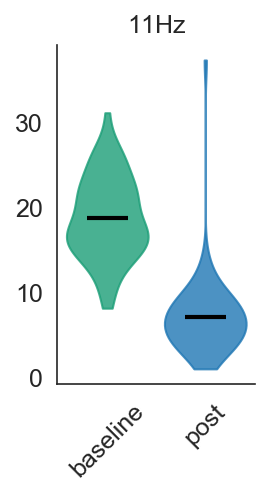

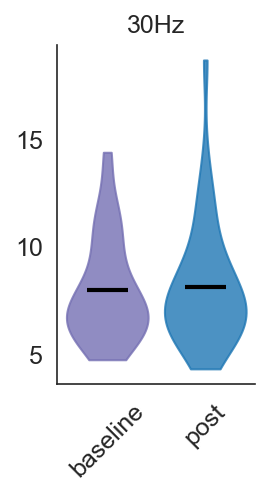

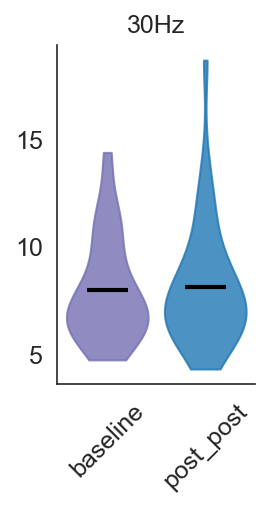

In [209]:
stim11 = stim_df.query("frequency == 11")
stim30 = stim_df.query("frequency == 30")

fig = plt.figure()
violinplot2(
    [stim11.psth_avg_baseline, stim11.psth_avg_post], 
    colors=['#1b9e77', "C0"],
    xticks=["baseline", "post"],
)
plt.title("11Hz")
# savefig()

fig = plt.figure()
violinplot2(
    [stim30.psth_avg_baseline, stim30.psth_avg_post], 
    colors=['#7570b3', "C0"],
    xticks=["baseline", "post"],
)
plt.title("30Hz")

fig = plt.figure()
violinplot2(
    [stim30.psth_avg_baseline, stim30.psth_avg_post_post], 
    colors=['#7570b3', "C0"],
    xticks=["baseline", "post_post"],
)
plt.title("30Hz")

# Save to expipe

In [ ]:
action = project.require_action("stimulus-response-post-response-inhibition")

In [ ]:
action.modules['parameters'] = {
    'window_size': window_size,
    'std_gaussian_kde': std_gaussian_kde,
    'tmin': tmin
}

In [ ]:
action.data['results'] = 'results.csv'
session_units_sig.to_csv(action.data_path('results'), index=False)

In [ ]:
copy_tree(output_path, str(action.data_path()))

In [ ]:
septum_mec.analysis.registration.store_notebook(action, "10-calculate-stimulus-response-fwhm.ipynb")